In [2]:
# Load some modules
import numpy as np
import matplotlib.pyplot as plt
import copy

## Panelverfahren für den Bodeneffekt
Im Folgenden erweitern unser einfaches Panelverfahren für die Simulation der stationären Umströmung eines dünnes Profils im Bodeneffekt. 

Zuerst definieren wir einige Input-Parameter, wie die Anzahl $N$ von Panelen, die Profilsehnenlänge $c$, die Anströmgeschwindigkeit $U$, die Profilmittellinie eines Profils der 4-Stelligen $\mathrm{NACA}$-Reihe und den Anstromwinkel $\alpha$. Im Vergleich zur vorigen Version, definieren audch einen dimensionslosen Abstand $d$ vom Flügelprofil zum Boden, ausgedrückt in Profilsehenlängen.

In [3]:
# Flow and discretisation parameters
alfa = 10 * np.pi / 180         # Angle of attack
N = 30                          # Number of panels to describe the airfoil
c = 1                           # Chord length
U = 1                           # Freestream velocity
NACA = [4,4,1,2]                # Four digits of the NACA profile to be considered
d = 0.3                         # Distance from the ground in chords

Jertzt können wir die Geometrie der Mittelline vom NACA-Profil definieren. 

In [4]:
# Define the geometry
def naca4(nums,x):
    m=nums[0]/100  
    p=nums[1]/10
    t=(nums[2]*10+nums[3])/100
    if x<=p:
        return c*m/(p**2)*(2*p*x-x**2)
    else:
        return c*m/((1-p)**2)*((1-2*p)+2*p*x-x**2)


Wenn die Mittellinie bekannt ist, können wir die Panele definieren, in dem wir einfach die Mittellinie in gerade Segmente teilen. Für jedes Segment können wir normale und tangente Einheitsvektoren definiren. Sie werden uns nützlich sein, um Geschwindigkeitskomponenten in die Richtung normal und parallel zum Profil zu bestimmen. Die Länge jedes Segments kann ebenfalls definiert werden. 

Es wird sich als praktisch erweisen, in diesem Fall das Profil um einen Winkel $\alpha$ um seine Nase zu drehen und horizontal anzuströmen, anstatt eine schräge Anströmung zu definieren. Das kann sehr einfach durch die Definition einer Rotationsmatrix erreicht werden, mit der wir alle Koordinate der Panele drehen können. 

Sind die Panele vollständig definiert, werden die Koordinaten der Potentialwirbel, des Kontrollpunkts und des Mittelpunkts von jedem Panel definiert. 

Die einzige Änderung zum Fall ohne Bodeneffekt ist, dass wir das Flügelprofil in die vertikale Richtung um einen Betrag $d$ verschieben, weil wir davon ausgehen werden, dass der Boden an der Stelle $y=0$ ist. 

In [5]:
# Define the panels
# 
# I use a dictionary to define the properties of each panel.
# Using a class would be a more elegant solution, but we just 
# use a dictionary here for simplicity. The members of the dictionaries
# are panel properties, such as:
#
# segment  -> the coordinates of the two ends of each panel
# normal   -> the normal to each panel
# tangent  -> the tangent direction to each panel
# length   -> the length of the panel
# vortex   -> the coordinates of the vortex placed on the panel (1/4 of panel length)
# midpoint -> the coordinates of the midpoint of each panel (1/2 of panel length)
# control  -> the coordinates of the control point on each panel (3/4 of panel length)
#
panels = dict()
panels['segment'] = np.zeros((2,2,N))   # Indices are: (iEnd, iCoord, iPanel)
panels['normal'] = np.zeros((2,N))      # Indices are: (iCoord, iPanel)
panels['tangent'] = np.zeros((2,N))     # Indices are: (iCoord, iPanel)
panels['length'] = np.zeros((N))        # Indices are: (iPanel)

# The freestream flow is always horizontal. The profile is rotated to account
# for the angle of attach with a rotation matrix Rmat. Nmat is a further 90° 
# rotation matrix, utilised to find the normal vector. 
Rmat = np.asarray([[np.cos(-alfa), -np.sin(-alfa)], [np.sin(-alfa), np.cos(-alfa)]])
Nmat = np.asarray([[0, -1], [1, 0]])

# Loop over all panels and define their segments, tangents, lengths and normals
for iP in range(N):
    xA = iP*c/N;    xB = (iP+1)*c/N
    panels['segment'][0,:,iP] = Rmat@np.asarray([xA, naca4(NACA,xA)])
    panels['segment'][1,:,iP] = Rmat@np.asarray([xB, naca4(NACA,xB)])
    panels['segment'][:,1,iP] += d     # Vertical shift of profile (Bodeneffekt)
    panels['tangent'][:,iP] = panels['segment'][1,:,iP] - panels['segment'][0,:,iP]
    panels['length'][iP] = np.linalg.norm(panels['tangent'][:,iP])
    panels['tangent'][:,iP] /= panels['length'][iP]
    panels['normal'][:,iP] = Nmat@panels['tangent'][:,iP]

# Once all segments are defined, also the position of the vortex-, 
# control- and midpoint can be defined 
panels['vortex'] = 3.0*panels['segment'][0]/4.0 + 1.0*panels['segment'][1]/4.0
panels['control'] = 1.0*panels['segment'][0]/4.0 + 3.0*panels['segment'][1]/4.0
panels['midpoint'] = 0.5*(panels['segment'][0] + panels['segment'][1])

Die Korrektheit der geometrischen Definition lässt sich mit einer graphischen Darstellung leicht überprüfen. 

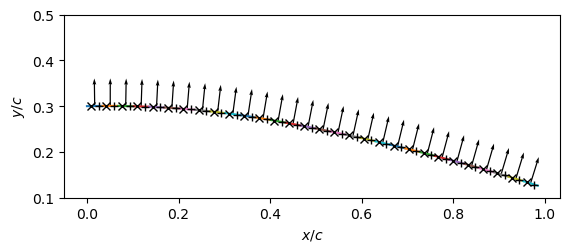

In [6]:
# Plot the panels, with their vortex- and controlpoints and the normals
plt.figure()
plt.plot(panels['segment'][:,0,:],panels['segment'][:,1,:])
plt.plot(panels['vortex'][0,:],panels['vortex'][1,:],'kx')
plt.plot(panels['control'][0,:],panels['control'][1,:],'k+')
plt.quiver(panels['midpoint'][0,:],panels['midpoint'][1,:], 
           panels['normal'][0,:], panels['normal'][1,:], width=0.0025)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel(r'$x/c$')
plt.ylabel(r'$y/c$')
plt.ylim([-0.2+d,d+0.2])
plt.show()

Wie vorher erwähnt, werden wir die von einem Potentialwirbel induzierte Geschwindigkeit in einem (Kontroll)Punkt oft im Panel-Verfahren berechnen müssen. Es lohnt sich also, diese Berechnung einer Funktion zu überlassen, welche hier unten implementiert wird. Die von einem Potentialwirbel induzierte Geschwindigkeit $\vec{w}$ hat den folgenden Ausdruck:
\begin{equation}
   \vec{w} = \frac{\Gamma}{2 \pi r} \hat{\theta} ,
\end{equation}
wobei ist $r$ der Betrag des Abstandsvektor $\vec{r}=\vec{x}_K - \vec{x}_W$ zwischen der Stelle des Kontrollpunkts $\vec{x}_K$ und des Wirbels $\vec{x}_W$, $\Gamma$ die Zirkulation des Wirbels und $\hat{\theta} = \hat{z} \times \vec{r}$ der lokale Einheitsvektor in Umfangsrichtung eines ziliyndrischen Koordinatensystems.  

In [7]:
# Define a function "vortexVelocity", which 
# computes the velocity induced at a point "ctrl",
# by a potential vortex placed at "vrtx" 
# with intensity "gamma"
def vortexVelocity(vrtx,ctrl,gamma,minr=0):
    r = ctrl-vrtx
    normr = np.linalg.norm(r)
    t = np.cross([0.0,0.0,1.0],[r[0],r[1],0.0])
    t /= np.linalg.norm(t)
    utheta = gamma/(2.0*np.pi*max([normr,minr]))
    return np.asarray([t[0]*utheta, t[1]*utheta])

Jetzt sind wir bereit, das Problem aufzustellen und zu lösen. Die $N$ unbekannte $\Gamma_i$-Werte der Zirkulation vom $i$-ten Panel werden durch die Forderung der Undurchlässigkeit an den $N$ Kontrollpunkten bestimmt. Diese Forderung für das allgemeine $j$-te Panel ist wie folgt mathematisch ausgedrückt:
\begin{equation}
\left( \vec{U}_\infty  + \sum_{i=1}^{N} \vec{w}_i(\vec{x}_{K_j}) \right) \cdot \hat{n}_j = 0 .
\end{equation}
Hier ist $\vec{w}_i(\vec{x}_{K_j})$ die vom $i$-ten Potentialwirbel induzierte Geschwindigkeit auf dem $j$-ten Kontrollpunkt. $\hat{n}_j$ ist die Normale zum $j$-ten Panel. Diese Gleichung stellt eine Zeile des Glecihungsystems dar. Wir stellen fest, dass der Term $\vec{U}_\infty \cdot \hat{n}_j$ bekannt ist und auf die rechte Seite gebracht werden kann, d.h.  
\begin{equation}
\sum_{i=1}^{N} \Gamma_i \vec{w}_{i,\Gamma=1}(\vec{x}_{K_j}) \cdot \hat{n}_j =  -\vec{U}_\infty \cdot  \hat{n}_j
\end{equation}
Hier wurde die Zirkulation $\Gamma_i$ des $i$-ten Wirbels explizit geschrieben, wobei jetzt $\vec{w}_{i,\Gamma=1}$ die vom $i$-ten Potentialwirbel mit Zirkulation $\Gamma_i=1$ induzierte Geschwindigkeit ist. Das ganze kann als Gleichungssystem 
\begin{equation}
\mathsf{A}\vec{\Gamma} = \vec{b} 
\end{equation}
umformt und gelöst werden. Benötigen Wir hierfür eine Kutta'sche Abflussbedingung?

Zuerst lösen wir einfach das ganz normale Problem ohne Bodeneffekt und berechnen am Ende die Gesamtzirkulation, damit wir diese mit dem Fall im Bodeneffekt vergleichen können.

In [28]:
# Define the influence matrix A and the right-hand-side b
A = np.zeros([N,N])
b = np.zeros([N])

# Compute A and b by looping over the the control points 
# (i.e. the equation, aka the rows of the matrix A)
# and the bound vortices (i.e. the columns of the matrix A)

# loop over control points
for iC,ctrl in enumerate(panels['control'].transpose()):
    # Apply the wall-normal component of the freestream to the r.h.s.
    b[iC] = -U*np.dot(np.asarray([1.0,0.0]), panels['normal'][:,iC])
    # loop over vortices
    for iV,vrtx in enumerate(panels['vortex'].transpose()):
        # Apply the velocity induced by every vortex on the control point
        A[iC,iV] = np.dot(vortexVelocity(vrtx,ctrl,1.0), panels['normal'][:,iC])
# solve the system A*Gamma = b and find the circulations
# of each bound potential vortex
Gamma = np.linalg.solve(A,b)
# compute the circulation density by dividing the
# circulation for each panel length
gamma = Gamma/panels['length']

print('Overall circulation without ground effect Gamma=' + str(np.sum(Gamma)))

Overall circulation without ground effect Gamma=-0.7631540843391107


Jetzt simulieren auch der Fall im Bodeneffekt mit der Spiegelbildmethode. Für jeden gebundenen Wirbel am Flügelprofil fügen wir ein Spielbild hinzu, gespiegelt um die $y$-Achse. Das heißt, für jeden gebundenen Wirbel an der Stelle $(x,y)$ mit Zirkulation $\Gamma_i$ haben wir einen zusätzlichen Wirbel an der Stelle $(x,-y)$ mit Zirkulation $-\Gamma_i$. Wir müssen also auch die von diesen gespielten Wirbeln induzierte Geschwindigkeit in die Matrix $\mathsf{A}$ hinzufügen. Deren Einfluss geht in die Matrix $\mathsf{A}$, weil die Zirkulation der gebundenen Wirbel noch unbekannt ist, und somit ist die Zirkulation der gespiegelten Wirbel auch unbekannt. Auch hier, muss das dünne Profil eine Stromlinie darstellen: Die Summe aller induzierten Geschwindigkeiten normal zum Profil muss null sein. 

In [29]:
# Simulate the ground effect via the mirror method

# loop over control points
for iC,ctrl in enumerate(panels['control'].transpose()):
    # loop over mirror vortices
    for iV,vrtx in enumerate(panels['vortex'].transpose()):
        # Apply the velocity induced by every vortex on the control point
        vimg = vrtx.copy(); vimg[1] *= -1.0
        A[iC,iV] += np.dot(vortexVelocity(vimg,ctrl,-1.0), panels['normal'][:,iC])
# solve the system A*Gamma = b and find the circulations
# of each bound potential vortex
Gamma_ge = np.linalg.solve(A,b)
# compute the circulation density by dividing the
# circulation for each panel length
gamma_ge = Gamma_ge/panels['length']

print('Overall circulation in ground effect ' + str(np.sum(Gamma_ge)))
dGamma = 100.0*(np.sum(Gamma_ge)-np.sum(Gamma))/np.sum(Gamma)
print('Due to ground effect the cirulation increased by ' + str("%.1f" % dGamma) + '%')

Overall circulation in ground effect -0.9428861331614931
Due to ground effect the cirulation increased by 23.6%


Nachdem die Lösung erhalten wurde, können wir das Geschwindigkeitsfeld um das Profil darstellen. Um dies zu tun, schreiben wir zwei Hilfsfunktionen ```flowVelocity``` und ```computeFlowField```, welche  die von allen Wirbeln und der Anströmung induzierte Geschwindigkeit jeweils in einem beliebigen Punkt und in mehreren Punkten verteilt auf einem Chartesischen Gitter rechnen.

Hier haben wir die Funktion ```flowVelocity``` angepasst. Sie nimmt auch den Parameter ```groundEffect``` als Input. Ist ```groundEffect``` als ```True``` gesetzt (das ist die Default-Einstellung), wird automatisch der Effekt des gespiegelten Wirbel berücksichtigt. 

In [31]:
# Define a function that given a dictionary
# of "panels", their circulation "Gamma", the
# freestream velocity "U" and a point with coordinates
# "x" and "y" computes the velocity field
def flowVelocity(x,y,panels,Gamma,U,groundEffect=True):
    # initialise the velocity with the freestream velocity
    u = U*np.asarray([1.0,0.0])
    # loop over all vortices
    for iV,vrtx in enumerate(panels['vortex'].transpose()):
        # add the vortex velocity via superposition
        u += vortexVelocity(vrtx,[x,y],Gamma[iV])
    if groundEffect:
        for iV,vrtx in enumerate(panels['vortex'].transpose()):
            vimg = vrtx.copy(); vimg[1] *= -1.0
            # add the vortex velocity via superposition
            u += vortexVelocity(vimg,[x,y],-Gamma[iV])
    return u

# Write a function that utilises flowVelocity to compute
# the flow field on a set of points given by the cartesian grid
# defined via two arrays of coordinates "x" and "y"
def computeFlowField(x,y,panels,Gamma,U,groundEffect=True):
    u = np.zeros([2,x.size,y.size])
    for ix,xx in enumerate(x):
        for iy,yy in enumerate(y):
            u[:,ix,iy] = flowVelocity(x[ix],y[iy],panels,Gamma,U)   
    return u

Jetzt kann das Geschwindigkeitsfeld tatsächlich berechnet werden.

In [32]:
# Define two arrays of coordinates "x" and "y"
# at which compute and plot the velocity field
x = np.linspace(-0.1,1.1,100)
y = np.linspace(-0.3+d,d+0.1,100)

# Compute the velocity field utilising "computeFlowField"
u = computeFlowField(x,y,panels,Gamma_ge,U)

Danach folgt die Darstellung beispielsweise durch Stromlinien mit ```matplotlib.pyplot.streamplot```.

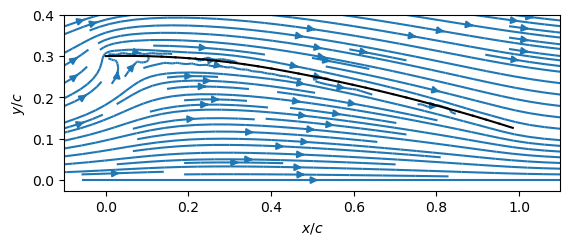

In [33]:
# Draw the panels and the velocity field by plotting
# streamlines with the function "streamplot" of "matplotlib.pyplot"
plt.figure()
plt.streamplot(x,y,u[0,:,:].transpose(),u[1,:,:].transpose())
plt.plot(panels['segment'][:,0,:],panels['segment'][:,1,:],'k')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel(r'$x/c$')
plt.ylabel(r'$y/c$')
plt.show()

Wir wollen die Differenz zwischen der Druck $p_t$ an der Oberseite und $p_b$ an der Unterseite des Profils quantifizieren. Das kann durch Bernoulli erreicht werden, z.B. 
\begin{equation}
 p_t - p_\infty =  \frac{1}{2} \rho \left(U_\infty^2 - \left| \vec{u}_t \right|^2 \right)
\end{equation}
\begin{equation}
 p_b - p_\infty =  \frac{1}{2} \rho \left(U_\infty^2 - \left| \vec{u}_b \right|^2 \right)
\end{equation}
wobei $\vec{u}_t$ und $\vec{u}_b$ die Geschwindigkeit an einem beliebigen Punkt der Ober- und Unterseite ist. Werden diese Gleichungen voneinander abgezogen und durch $ \frac{1}{2} \rho U_\infty^2$ dividiert, erhält man:
\begin{equation}
 \frac{p_t - p_b}{\frac{1}{2} \rho U_\infty^2} =  \Delta c_p = \frac{\left| \vec{u}_b  \right|^2 - \left| \vec{u}_t \right|^2}{U_\infty^2} 
\end{equation}
Gleichzeitig kann die Druckdifferenz zwischen Ober- und Unterseite des $j$-ten Panels (ein Panel ist selbst ein dunnes Profil!) durch die Auftriebskraft pro Längen- und Tiefeneinheit durch Kutta--Joukowski berechner werden, d.h.
\begin{equation}
 \frac{p_{j,t} - p_{j,b}}{\frac{1}{2} \rho U_\infty^2} = \Delta c_{p,j} = \frac{L_j^\prime / \ell_j}{\frac{1}{2} \rho U_\infty^2} = \frac{\rho U_\infty \Gamma_j / \ell_j}{\frac{1}{2} \rho U_\infty^2} =  \frac{\rho U_\infty \gamma_j}{\frac{1}{2} \rho U_\infty^2}
\end{equation}
wobei hier stellt $L_j^\prime$ den Auftrieb pro Tiefeneinheit, $\Gamma_j$ die Zirkulation des $j$-ten Panels und $\ell_j$ die Länge des Panels dar. Der Ausdruck mit den quadrierten Geschwindigkeiten kann verwendet werden, um dieselbe Druckdifferenz für Profile mit dünner aber endlicher Dicke zu ermitteln, wie sie z.B. durch XFOIL potentialtheoretisch zu simulieren sind. Im Folgenden vergleichen wir unser Ergebnis mit dem Ergebnis von XFOIL für ein ähnliches Profil mit endlicher Dicke mit dem Ziel, die Ergebnisse zu validieren. Stimmen die Ergebnisse überein?

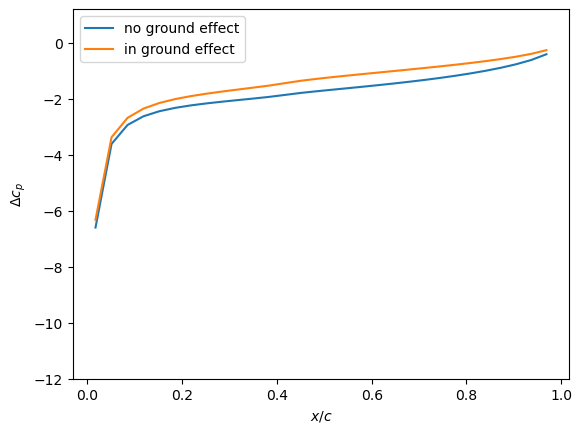

In [34]:
# Compute and plot the difference of cp between the 
# top and the bottom surface and compare it with 
# the results obtained with XFOIL for a profile of thin
# but finite thickness (e.g. NACA 4401)
plt.figure()

# Load the data from XFOIL
ul = np.loadtxt('ue_lower.txt')
ul = np.interp(panels['midpoint'][0,:], ul[:,1], ul[:,3])
uu = np.loadtxt('ue_upper.txt'); uu = uu[::-1,:]
uu = np.interp(panels['midpoint'][0,:], uu[:,1], uu[:,3])
# Compute the pressure coefficient difference from XFOIL data
u = (ul+uu); cp = ul**2-uu**2

# Plot \Delta cp from present data and compare it with XFOIL
plt.plot(panels['midpoint'][0,:],2*gamma_ge,label='no ground effect')
plt.plot(panels['midpoint'][0,:],2*gamma,label='in ground effect')
plt.legend()
plt.ylim([-12,1.2])
plt.xlabel(r'$x/c$')
plt.ylabel(r'$\Delta c_p$')
plt.show()